<a href="https://colab.research.google.com/github/newh08/AI_Voyage/blob/main/3%E1%84%8C%E1%85%AE%E1%84%8E%E1%85%A1_%E1%84%80%E1%85%B5%E1%84%87%E1%85%A9%E1%86%AB%E1%84%80%E1%85%AA%E1%84%8C%E1%85%A6_DistilVERT_fine_tuning_d%E3%85%A1%E1%84%85%E1%85%A9_%E1%84%80%E1%85%A1%E1%86%B7%E1%84%8C%E1%85%A5%E1%86%BC_%E1%84%87%E1%85%AE%E1%86%AB%E1%84%89%E1%85%A5%E1%86%A8_%E1%84%86%E1%85%A9%E1%84%83%E1%85%A6%E1%86%AF_%E1%84%92%E1%85%A1%E1%86%A8%E1%84%89%E1%85%B3%E1%86%B8%E1%84%92%E1%85%A1%E1%84%80%E1%85%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## [MYCODE] AG_News dataset 준비

- ag_news 데이터 불러오기
- Truncation과 관련된 부분 지우기

In [4]:
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

# Huggingface dataset의 fancyzhx/ag_news를 load하기.
ds = load_dataset("ag_news")


def collate_fn(batch):
  #max_len = 400 -> Truncation과 관련된 부분들을 지우기
  texts, labels = [], []
  for row in batch:
    labels.append(row['label'])
    texts.append(row['text'])

  texts = torch.LongTensor(tokenizer(texts, padding=True).input_ids) # -> Truncation과 관련된 부분들을 지우기
  labels = torch.LongTensor(labels)

  return texts, labels


train_loader = DataLoader(
    ds['train'], batch_size=64, shuffle=True, collate_fn=collate_fn
)
test_loader = DataLoader(
    ds['test'], batch_size=64, shuffle=False, collate_fn=collate_fn
)

text, label = next(iter(train_loader))
print(text.shape, label.shape)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

torch.Size([64, 116]) torch.Size([64])


## [LOG] 데이터의 text길이, 라벨 종류 확인하기

In [15]:
import numpy as np
import matplotlib.pyplot as plt

def live_plot(train_accs, test_accs, title="Real-time Accuracy", label1='train', label2='test'):
    # 플롯 크기 설정
    plt.figure(figsize=(10, 8))

    # 1번째 서브플롯: Train_loss vs test
    plt.subplot(2, 1, 1)
    x = np.arange(len(train_accs))
    plt.plot(x, train_accs, label='train', color='blue')
    plt.plot(x, test_accs, label='test', color='red', marker='o')
    plt.title("Train_acc vs Test_acc")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()


    # 플롯 간격 조정 및 출력
    plt.tight_layout()
    plt.show()

def analyze_datasets(loader):
    all_lengths = []
    all_labels = []

    for texts, labels in loader:
        all_lengths.append(texts.size(1))
        all_labels.extend(labels.tolist())

    max_length = max(all_lengths)
    unique_labels = set(all_labels)

    return max_length, unique_labels


# Train과 Test 로더 통합 분석
max_length, unique_labels = analyze_datasets(train_loader)
print(f"train 데이터셋 - text의 최대 길이: {max_length}")
print(f"train 데이터셋 - label의 종류: {unique_labels}")

max_length, unique_labels = analyze_datasets(test_loader)
print(f"test 데이터셋 - text의 최대 길이: {max_length}")
print(f"test 데이터셋 - label의 종류: {unique_labels}")


train 데이터셋 - text의 최대 길이: 379
train 데이터셋 - label의 종류: {0, 1, 2, 3}
test 데이터셋 - text의 최대 길이: 277
test 데이터셋 - label의 종류: {0, 1, 2, 3}


## [MYCODE] 모델 정의, 정확도 함수 변경, 손실함수 변경

In [13]:
from torch import nn
from torch.optim import Adam

class NewsClassifier(nn.Module):
    def __init__(self):
        super().__init__()

        # DistilBERT 모델 로드
        self.encoder = AutoModel.from_pretrained('distilbert-base-uncased')
        self.classifier = nn.Linear(768, 4)

    def forward(self, x):
        # DistilBERT 출력
        outputs = self.encoder(x)
        # [CLS] 토큰의 마지막 히든 상태만 가져오기
        CLS_token = outputs['last_hidden_state'][:,0]
        x = self.classifier(CLS_token)
        return x


model = NewsClassifier()

# 입력 준비
long_text = "This is a long text. " * 70
texts = ["This is a sample sentence.", "This is another example.", long_text,long_text]
encoded = tokenizer(
    texts,
    padding=True,
    truncation=True,
    max_length=400,
    return_tensors="pt"
)

# 모델에 입력 전달해 출력 확인해보기
input_ids = encoded['input_ids']
output = model(input_ids)
print(f"NewsClassifier Result: {output}")

# 평가함수
def news_accuracy(model, dataloader):
  cnt = 0
  acc = 0

  model.eval()
  with torch.no_grad():
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda')

        preds = model(inputs)
        preds = torch.argmax(preds, dim=-1) # 가장 높은 점수 선택

        cnt += labels.shape[0]
        acc += (labels == preds).sum().item()

  return acc / cnt

lr = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=lr)
n_epochs = 10

# 파인 튜닝을 위한 학습시 기존 모델의 파라미터 변경하지 않기.
for param in model.encoder.parameters():
  param.requires_grad = False

NewsClassifier Result: tensor([[ 0.0899,  0.2951,  0.0147, -0.2047],
        [ 0.0856,  0.3095, -0.0025, -0.2297],
        [-0.0406,  0.4934, -0.3267,  0.0157],
        [-0.0406,  0.4934, -0.3267,  0.0157]], grad_fn=<AddmmBackward0>)


## [LOG] 파인튜닝 모델 학습 및 평가.


Epoch 1/10:   0%|          | 0/1875 [00:00<?, ?batch/s]

Epoch 2/10:   0%|          | 0/1875 [00:00<?, ?batch/s]

Epoch 3/10:   0%|          | 0/1875 [00:00<?, ?batch/s]

Epoch 4/10:   0%|          | 0/1875 [00:00<?, ?batch/s]

Epoch 5/10:   0%|          | 0/1875 [00:00<?, ?batch/s]

Epoch 6/10:   0%|          | 0/1875 [00:00<?, ?batch/s]

Epoch 7/10:   0%|          | 0/1875 [00:00<?, ?batch/s]

Epoch 8/10:   0%|          | 0/1875 [00:00<?, ?batch/s]

Epoch 9/10:   0%|          | 0/1875 [00:00<?, ?batch/s]

Epoch 10/10:   0%|          | 0/1875 [00:00<?, ?batch/s]

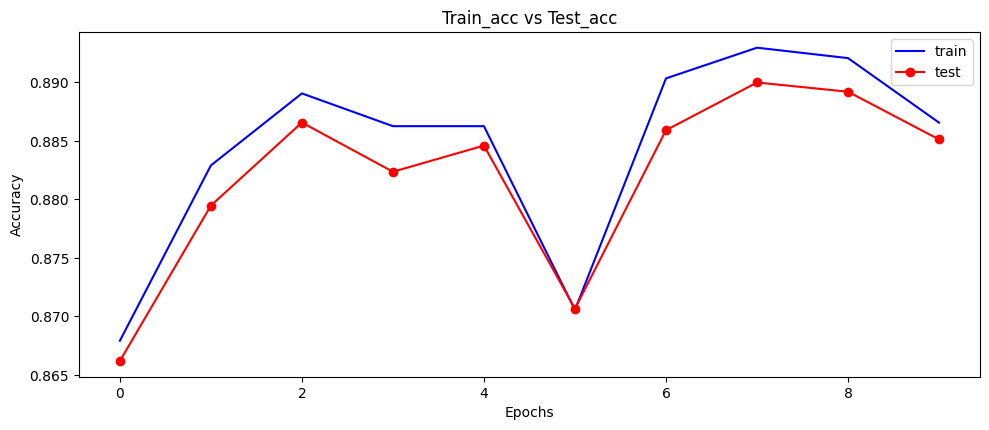

In [14]:
from tqdm.notebook import tqdm

train_accs = []
test_accs = []
model = model.to('cuda')

for epoch in range(n_epochs):
  with tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epochs}", unit="batch") as pbar:
    model.train()
    for data in train_loader:
      model.zero_grad()
      inputs, labels = data
      inputs, labels = inputs.to('cuda'), labels.to('cuda').long()

      preds = model(inputs)

      loss = loss_fn(preds, labels)
      loss.backward()
      optimizer.step()
      pbar.set_postfix(loss=loss.item())
    with torch.no_grad():
      model.eval()
      train_acc = news_accuracy(model, train_loader)
      test_acc = news_accuracy(model, test_loader)
      train_accs.append(train_acc)
      test_accs.append(test_acc)
live_plot(train_accs,test_accs)